<a href="https://colab.research.google.com/github/kunakl07/Killer-Whale-sound-classification/blob/master/Standardize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

!git clone https://github.com/axiom-data-science/OrcaCNN-data
import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm

DATA_PATH = "/content/OrcaCNN-data/data/training/"


# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

#saving data to array
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)


def get_train_test(split_ratio=0.6, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)



def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            # Downsampling
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(wave, sr=16000)
            vectors.append(mfcc)

        data[label]['mfcc'] = vectors

    return data


def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]






fatal: destination path 'OrcaCNN-data' already exists and is not an empty directory.


In [0]:
rm /content/OrcaCNN-data/data/training/positive/class_labels.json

rm: cannot remove '/content/OrcaCNN-data/data/training/positive/class_labels.json': No such file or directory


In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

### Second dimension of the feature is dim2
feature_dim_2 = 11

### Save data to array file first
save_data_to_array(max_len=feature_dim_2)

### Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

### Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 1200
batch_size = 100
verbose = 1
num_classes = 2

### Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)


Saving vectors of label - 'negative': 100%|██████████| 25/25 [00:01<00:00, 13.56it/s]


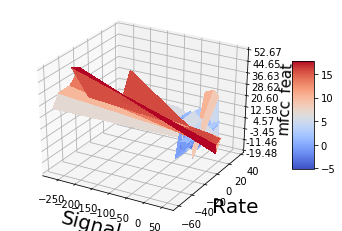

In [0]:
#Without Standardization

values=np.load("/content/positive.npy")

x=values[0]
y=values[1]
z=values[2]

from matplotlib.ticker import LinearLocator, FormatStrFormatter

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = fig.gca(projection='3d')

R = np.sqrt(x**2 + y**2)
ax.set_xlabel("$Rate",fontsize=20)
ax.set_ylabel("Quality",fontsize=20)
ax.set_zlabel("Z",fontsize=15)
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("Signal",fontsize=20)
ax.set_ylabel("Rate",fontsize=20)
ax.set_zlabel("mfcc_feat",fontsize=15)# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

values=np.load("/content/positive.npy")


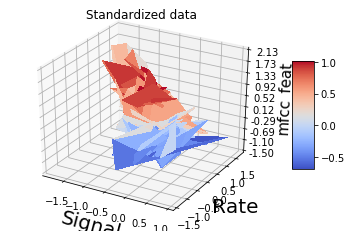

In [0]:
#With standardization
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from math import sqrt
values=np.load("/content/positive.npy")
X_train=values

##Standardizing each numpy array using StandardScalar function 

scalers = {}
###standardizing n where n is Rate
for i in range(X_train.shape[2]):
    scalers[i] = StandardScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
###standardizing m where m is Signal 
for i in range(X_train.shape[2]):
    scalers[i] = StandardScaler()
    X_train[i, :, :] = scalers[i].fit_transform(X_train[i, :, :]) 
###standardizing p where p is mfcc_feat
for i in range(X_train.shape[2]):
    scalers[i] = StandardScaler()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])     

x=X_train[0]
y=X_train[1]
z=X_train[2]
##Now once standardize we are going to plot using matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = fig.gca(projection='3d')
R = np.sqrt(x**2 + y**2)

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("Signal",fontsize=20)
ax.set_ylabel("Rate",fontsize=20)
ax.set_zlabel("mfcc_feat",fontsize=15)
### Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Standardized data')

plt.show()


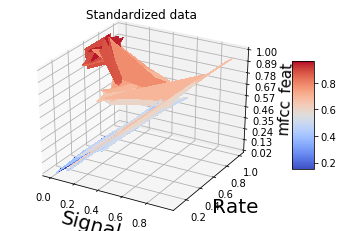

In [0]:
#With standardization
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
values=np.load("/content/positive.npy")
X_train=values

##Standardizing each numpy array using StandardScalar function 
#scaler = MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()
scalers={}


###standardizing n where n is Rate
for i in range(X_train.shape[2]):
  
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
###standardizing m where m is Signal 
for i in range(X_train.shape[2]):
    scalers[i] = MinMaxScaler()
    X_train[i, :, :] = scalers[i].fit_transform(X_train[i, :, :]) 
###standardizing p where p is mfcc_feat
for i in range(X_train.shape[2]):
    scalers[i] = MinMaxScaler()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])     

x=X_train[0]
y=X_train[1]
z=X_train[2]
##Now once standardize we are going to plot using matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = fig.gca(projection='3d')
R = np.sqrt(x**2 + y**2)

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("Signal",fontsize=20)
ax.set_ylabel("Rate",fontsize=20)
ax.set_zlabel("mfcc_feat",fontsize=15)
### Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Standardized data')

plt.show()


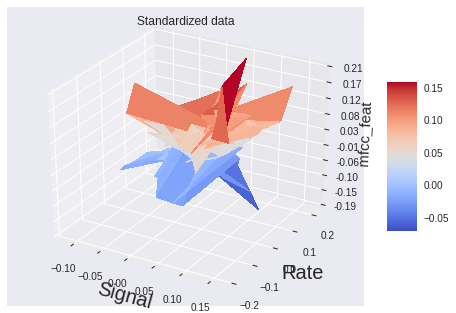

In [0]:
from sklearn.preprocessing import MaxAbsScaler
#With standardization
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
values=np.load("/content/positive.npy")
X_train=values

##Standardizing each numpy array using StandardScalar function 
#scaler = MinMaxScaler()
min_max_scaler = preprocessing.MaxAbsScaler()
scalers={}


###standardizing n where n is Rate
for i in range(X_train.shape[2]):
  
    scalers[i] = MaxAbsScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
###standardizing m where m is Signal 
for i in range(X_train.shape[2]):
    scalers[i] = MaxAbsScaler()
    X_train[i, :, :] = scalers[i].fit_transform(X_train[i, :, :]) 
###standardizing p where p is mfcc_feat
for i in range(X_train.shape[2]):
    scalers[i] = MaxAbsScaler()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])     

x=X_train[0]
y=X_train[1]
z=X_train[2]
##Now once standardize we are going to plot using matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = fig.gca(projection='3d')
R = np.sqrt(x**2 + y**2)

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("Signal",fontsize=20)
ax.set_ylabel("Rate",fontsize=20)
ax.set_zlabel("mfcc_feat",fontsize=15)
### Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Standardized data')

plt.show()


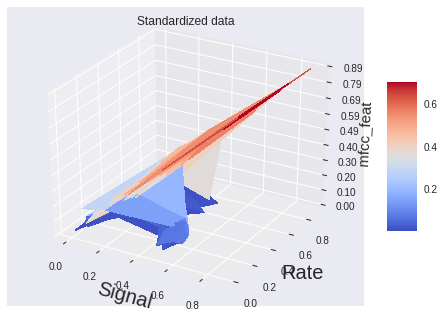

In [0]:
#With standardization
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
values=np.load("/content/positive.npy")
X_train=values

##Standardizing each numpy array using StandardScalar function 
#scaler = MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()
scalers={}


###standardizing n where n is Rate
for i in range(X_train.shape[2]):
  
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
###standardizing m where m is Signal 
for i in range(X_train.shape[2]):
    scalers[i] = MinMaxScaler()
    X_train[i, :, :] = scalers[i].fit_transform(X_train[i, :, :]) 
###standardizing p where p is mfcc_feat
for i in range(X_train.shape[2]):
    scalers[i] = MinMaxScaler()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])     

x=X_train[0]
y=X_train[1]
z=X_train[2]
##Now once standardize we are going to plot using matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = fig.gca(projection='3d')
R = np.sqrt(x**2 + y**2)

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("Signal",fontsize=20)
ax.set_ylabel("Rate",fontsize=20)
ax.set_zlabel("mfcc_feat",fontsize=15)
### Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Standardized data')

plt.show()


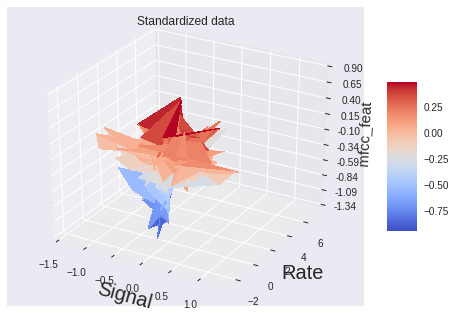

In [0]:
from sklearn.preprocessing import RobustScaler
#With standardization
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
values=np.load("/content/positive.npy")
X_train=values

##Standardizing each numpy array using StandardScalar function 
#scaler = MinMaxScaler()
min_max_scaler = preprocessing.RobustScaler()
scalers={}


###standardizing n where n is Rate
for i in range(X_train.shape[2]):
  
    scalers[i] = RobustScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
###standardizing m where m is Signal 
for i in range(X_train.shape[2]):
    scalers[i] = RobustScaler()
    X_train[i, :, :] = scalers[i].fit_transform(X_train[i, :, :]) 
###standardizing p where p is mfcc_feat
for i in range(X_train.shape[2]):
    scalers[i] = RobustScaler()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])     

x=X_train[0]
y=X_train[1]
z=X_train[2]
##Now once standardize we are going to plot using matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = fig.gca(projection='3d')
R = np.sqrt(x**2 + y**2)

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("Signal",fontsize=20)
ax.set_ylabel("Rate",fontsize=20)
ax.set_zlabel("mfcc_feat",fontsize=15)
### Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Standardized data')

plt.show()


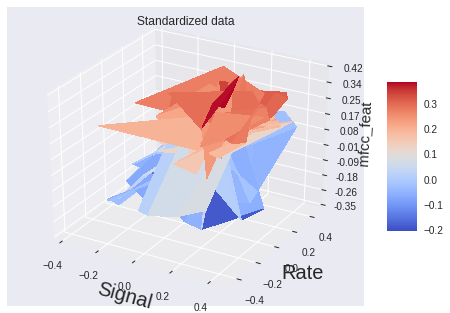

In [0]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
#With standardization
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
values=np.load("/content/positive.npy")
X_train=values

##Standardizing each numpy array using StandardScalar function 
#scaler = MinMaxScaler()
min_max_scaler = preprocessing.Normalizer()
scalers={}


###standardizing n where n is Rate
for i in range(X_train.shape[2]):
  
    scalers[i] = Normalizer()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
###standardizing m where m is Signal 
for i in range(X_train.shape[2]):
    scalers[i] = Normalizer()
    X_train[i, :, :] = scalers[i].fit_transform(X_train[i, :, :]) 
###standardizing p where p is mfcc_feat
for i in range(X_train.shape[2]):
    scalers[i] = Normalizer()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])     

x=X_train[0]
y=X_train[1]
z=X_train[2]
##Now once standardize we are going to plot using matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = fig.gca(projection='3d')
R = np.sqrt(x**2 + y**2)

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("Signal",fontsize=20)
ax.set_ylabel("Rate",fontsize=20)
ax.set_zlabel("mfcc_feat",fontsize=15)
### Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Standardized data')

plt.show()


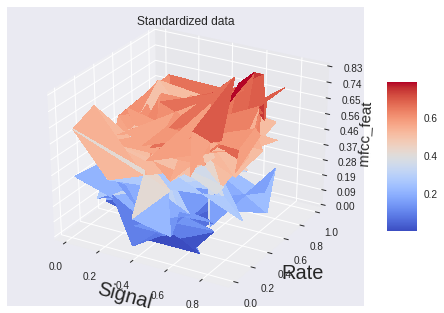

In [0]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
#With standardization
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
values=np.load("/content/positive.npy")
X_train=values

##Standardizing each numpy array using StandardScalar function 
#scaler = MinMaxScaler()
min_max_scaler = preprocessing.QuantileTransformer()
scalers={}


###standardizing n where n is Rate
for i in range(X_train.shape[2]):
  
    scalers[i] = QuantileTransformer()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
###standardizing m where m is Signal 
for i in range(X_train.shape[2]):
    scalers[i] = QuantileTransformer()
    X_train[i, :, :] = scalers[i].fit_transform(X_train[i, :, :]) 
###standardizing p where p is mfcc_feat
for i in range(X_train.shape[2]):
    scalers[i] = QuantileTransformer()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])     

x=X_train[0]
y=X_train[1]
z=X_train[2]
##Now once standardize we are going to plot using matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = fig.gca(projection='3d')
R = np.sqrt(x**2 + y**2)

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("Signal",fontsize=20)
ax.set_ylabel("Rate",fontsize=20)
ax.set_zlabel("mfcc_feat",fontsize=15)
### Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Standardized data')

plt.show()


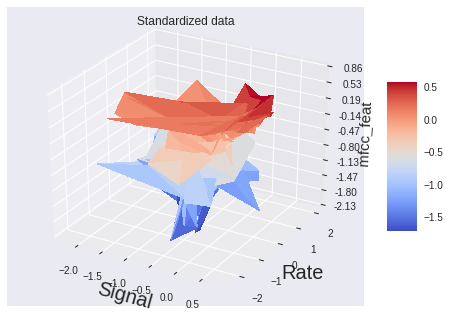

In [0]:
from sklearn.preprocessing import PowerTransformer

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
#With standardization
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
values=np.load("/content/positive.npy")
X_train=values

##Standardizing each numpy array using StandardScalar function 
#scaler = MinMaxScaler()
min_max_scaler = preprocessing.PowerTransformer()
scalers={}


###standardizing n where n is Rate
for i in range(X_train.shape[2]):
  
    scalers[i] = PowerTransformer()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
###standardizing m where m is Signal 
for i in range(X_train.shape[2]):
    scalers[i] = PowerTransformer()
    X_train[i, :, :] = scalers[i].fit_transform(X_train[i, :, :]) 
###standardizing p where p is mfcc_feat
for i in range(X_train.shape[2]):
    scalers[i] = PowerTransformer()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])     

x=X_train[0]
y=X_train[1]
z=X_train[2]
##Now once standardize we are going to plot using matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = fig.gca(projection='3d')
R = np.sqrt(x**2 + y**2)

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel("Signal",fontsize=20)
ax.set_ylabel("Rate",fontsize=20)
ax.set_zlabel("mfcc_feat",fontsize=15)
### Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Standardized data')

plt.show()
